In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from collections import OrderedDict
from PIL import Image
import matplotlib.patches as patches
import keras
from sklearn.model_selection import train_test_split
import shutil
from shutil import unpack_archive
from subprocess import check_output
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, AveragePooling2D
from tensorflow.keras.optimizers import Adam, SGD, Adadelta
from tensorflow.python.keras import regularizers 

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import metrics 
from pylab import rcParams
#from sklearn.datasets import make_moons
from sklearn.cluster import SpectralClustering
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

data_directory = "/content/drive/MyDrive/Datasets/lwf_archive/lfw_funneled/"

In [2]:
def directory_mover(data, dir_name): #function that move directory from another directory
  co = 0
  for image in data.image_path:
        # create top directory
        if not os.path.exists(os.path.join('/content/drive/MyDrive/Datasets/lwf_archive/lfw_kaggle/working/',dir_name)):
            shutil.os.mkdir(os.path.join('/content/drive/MyDrive/Datasets/lwf_archive/lfw_kaggle/working/',dir_name))
        
        data_type = data[data['image_path'] == image]['name']
        data_type = str(list(data_type)[0])
        if not os.path.exists(os.path.join('/content/drive/MyDrive/Datasets/lwf_archive/lfw_kaggle/working/',dir_name,data_type)):
            shutil.os.mkdir(os.path.join('/content/drive/MyDrive/Datasets/lwf_archive/lfw_kaggle/working/',dir_name,data_type))
        path_from = os.path.join(data_directory, image)
        path_to = os.path.join('/content/drive/MyDrive/Datasets/lwf_archive/lfw_kaggle/working/',dir_name,data_type)
        # print(path_to)
        shutil.copy(path_from, path_to)
        # print('Moved {} to {}'.format(image,path_to))
        co += 1
        
  print('Moved {} images to {} folder.'.format(co,dir_name))

In [3]:
lfw_allnames_data = pd.read_csv("/content/drive/MyDrive/Datasets/lfw_csv/lfw_allnames.csv")
matchpairsDevTestData = pd.read_csv("/content/drive/MyDrive/Datasets/lfw_csv/matchpairsDevTest.csv")
matchpairDevTrainData = pd.read_csv("/content/drive/MyDrive/Datasets/lfw_csv/matchpairsDevTrain.csv")
mismatchpairDevTestData = pd.read_csv("/content/drive/MyDrive/Datasets/lfw_csv/mismatchpairsDevTest.csv")
mismatchpairDevTrainData = pd.read_csv("/content/drive/MyDrive/Datasets/lfw_csv/mismatchpairsDevTrain.csv")
pairs = pd.read_csv("/content/drive/MyDrive/Datasets/lfw_csv/pairs.csv")

pairs = pairs.rename(columns={'name': 'name1', 'Unnamed: 3': 'name2'})
matched_pairs = pairs[pairs['name2'].isnull()].drop("name2", axis=1)
mismatchedpairs = pairs[pairs['name2'].notnull()]
people = pd.read_csv("/content/drive/MyDrive/Datasets/lfw_csv/people.csv")

people = people[people.name.notnull()]
peopleDevTestData = pd.read_csv("/content/drive/MyDrive/Datasets/lfw_csv/peopleDevTest.csv")
peopleDevTrainData = pd.read_csv("/content/drive/MyDrive/Datasets/lfw_csv/peopleDevTrain.csv")

In [4]:
#shape the data set
image_paths = lfw_allnames_data.loc[lfw_allnames_data.index.repeat(lfw_allnames_data['images'])]
image_paths['image_path'] = 1 + image_paths.groupby('name').cumcount()
image_paths['image_path'] = image_paths.image_path.apply(lambda x: '{0:0>4}'.format(x))
image_paths['image_path'] = image_paths.name + "/" + image_paths.name + "_" + image_paths.image_path + ".jpg"
image_paths = image_paths.drop("images", 1)

lfw_train_data, lfw_test_data = train_test_split(image_paths, test_size=0.2) #test data - train data
lfw_train_data = lfw_train_data.reset_index().drop("index", 1) #drop the index 1
lfw_test_data = lfw_test_data.reset_index().drop("index", 1) #drop the index 2

print(len(set(lfw_train_data.name).intersection(set(lfw_test_data.name))))
print(len(set(lfw_test_data.name) - set(lfw_train_data.name)))


845
838


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  # Remove the CWD from sys.path while we load stuff.


In [5]:
multi_data_direct = pd.concat([image_paths[image_paths.name=="George_W_Bush"].sample(75),
                      image_paths[image_paths.name=="Colin_Powell"].sample(75),
                      image_paths[image_paths.name=="Tony_Blair"].sample(75),
                      image_paths[image_paths.name=="Donald_Rumsfeld"].sample(75),
                      image_paths[image_paths.name=="Gerhard_Schroeder"].sample(75),
                      image_paths[image_paths.name=="Ariel_Sharon"].sample(75)])

In [6]:
from keras.layers.core.dropout import Dropout
from keras.layers.normalization.batch_normalization import BatchNormalization
multi_train_data, multi_test_data = train_test_split(multi_data_direct, test_size=0.2)
multi_train_data, multi_vali_data = train_test_split(multi_train_data, test_size=0.2)

model_lfw = Sequential()
model_lfw.add(Conv2D(32, (3,3), strides = 2, padding = "same", activation = 'relu', kernel_regularizer = regularizers.l2(l = 0.01), input_shape = (250, 250, 3)))
model_lfw.add(Conv2D(32, (3,3), strides = 2, padding = "same", activation = 'relu', kernel_regularizer=regularizers.l2(l = 0.01)))
model_lfw.add(BatchNormalization())
model_lfw.add(MaxPooling2D(pool_size = (3,3), strides = 2, padding = "same"))
#model_lfw.add(BatchNormalization())
model_lfw.add(Conv2D(64, (3,3), strides = 2, padding = "same", activation = 'relu', kernel_regularizer=regularizers.l2(l = 0.01)))
model_lfw.add(Conv2D(64, (3,3), strides = 2, padding = "same", activation= 'relu', kernel_regularizer=regularizers.l2(l = 0.01)))
model_lfw.add(BatchNormalization())
model_lfw.add(MaxPooling2D(pool_size = (3,3), strides = 2, padding = "same"))
model_lfw.add(Conv2D(64, (3,3), strides = 2, padding = "same", activation= 'relu', kernel_regularizer=regularizers.l2(l = 0.01)))
model_lfw.add(AveragePooling2D(pool_size = (2, 2), strides = (1, 1), padding = "same"))
model_lfw.add(Flatten())
model_lfw.add(Dense(units = 128, activation = 'relu'))
model_lfw.add(Dropout(0.5))
#model_lfw.add(Conv2D(32, (3,3), input_shape = (250, 250, 3), activation = 'relu'))
#model_lfw.add(MaxPooling2D(pool_size = (3,3)))
#model_lfw.add(Flatten())
#model_lfw.add(Dense(units = 128, activation='relu'))

model_lfw.add(Dense(units=6, activation='softmax'))


In [7]:
optimizer_2 = SGD(learning_rate=0.01, momentum = 0.99, nesterov = True, name = "SGD")
model_lfw.compile(optimizer=optimizer_2, loss="categorical_crossentropy", metrics=['accuracy'])

#directory_mover(multi_train_data, "train_multi/")

In [10]:
#directory_mover(multi_vali_data, 'val_multi/')
#directory_mover(multi_test_data, 'test_multi/')
callback = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience = 10, mode = 'max') #10 epoch da değişim olmazsa dur patience = 10
train_datagen_lfw = keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                 shear_range=0.2,
                                                                 zoom_range=0.2,
                                                                 horizontal_flip=True)
test_datagen_lfw = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

multi_lfw_train_set = train_datagen_lfw.flow_from_directory("/content/drive/MyDrive/Datasets/lwf_archive/lfw_kaggle/working/train_multi/",
                                                            target_size = (250, 250),
                                                            batch_size = 32,
                                                            class_mode = "categorical")
multi_lfw_val_set = test_datagen_lfw.flow_from_directory("/content/drive/MyDrive/Datasets/lwf_archive/lfw_kaggle/working/val_multi/",
                                                           target_size = (250, 250),
                                                           batch_size = 32,
                                                           class_mode = "categorical"
                                                         )
history_lfw = model_lfw.fit(multi_lfw_train_set, epochs=50, callbacks = [callback], validation_data=multi_lfw_val_set)

Found 288 images belonging to 6 classes.
Found 72 images belonging to 6 classes.
Epoch 1/50
9/9 [==============================] - 10s 1s/step - loss: 2.8088 - accuracy: 0.3715 - val_loss: 4.1995 - val_accuracy: 0.1667
Epoch 2/50
9/9 [==============================] - 10s 1s/step - loss: 2.7628 - accuracy: 0.3403 - val_loss: 3.2100 - val_accuracy: 0.2361
Epoch 3/50
9/9 [==============================] - 10s 1s/step - loss: 2.6435 - accuracy: 0.3507 - val_loss: 3.2248 - val_accuracy: 0.2361
Epoch 4/50
9/9 [==============================] - 10s 1s/step - loss: 2.4894 - accuracy: 0.3819 - val_loss: 2.9580 - val_accuracy: 0.2222
Epoch 5/50
9/9 [==============================] - 10s 1s/step - loss: 2.4442 - accuracy: 0.3611 - val_loss: 2.8100 - val_accuracy: 0.2500
Epoch 6/50
9/9 [==============================] - 10s 1s/step - loss: 2.5057 - accuracy: 0.2396 - val_loss: 2.6664 - val_accuracy: 0.1389
Epoch 7/50
9/9 [==============================] - 10s 1s/step - loss: 2.4011 - accuracy: 0.

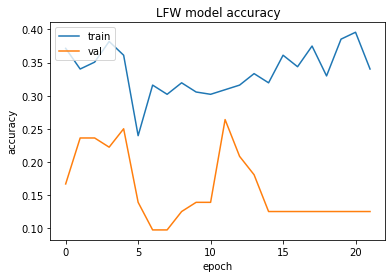

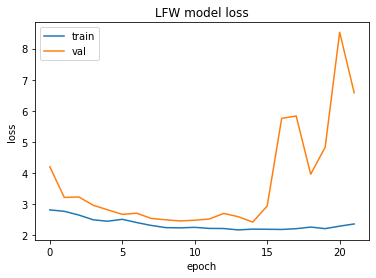

In [11]:
plt.plot(history_lfw.history['accuracy'])
plt.plot(history_lfw.history['val_accuracy'])
plt.title("LFW model accuracy")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history_lfw.history['loss'])
plt.plot(history_lfw.history['val_loss'])
plt.title('LFW model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [12]:
#STD deneme FFHQ veri seti
path = r"/content/drive/MyDrive/Datasets/lwf_archive/FFHQ/" #FFHQ dataset

os.chdir(path)

faces = []

with os.scandir(path) as files:
  for file in files:
    if file.name.endswith('.png'):
      faces.append(file)



In [14]:
print(len(faces))
print(faces[:10])

3320
[<DirEntry '68834.png'>, <DirEntry '69138.png'>, <DirEntry '68706.png'>, <DirEntry '69038.png'>, <DirEntry '68783.png'>, <DirEntry '68663.png'>, <DirEntry '68691.png'>, <DirEntry '68785.png'>, <DirEntry '68746.png'>, <DirEntry '68766.png'>]


In [15]:
from keras.models import Model
model_try = Model(inputs = model_lfw.inputs, outputs = model_lfw.layers[-2].output)

def CNN_face(file, model):
  img = load_img(file, target_size = (250, 250))

  img = np.array(img)

  reshaped_image = img.reshape(1, 250, 250, 3)

  imgx = preprocess_input(reshaped_image)

  features = model.predict(imgx, use_multiprocessing=True)

  return features

In [17]:
data = {}

for face in faces:
  feat = CNN_face(face, model_try)
  data[face] = feat

file_names = np.array(list(data.keys())) #get the keys

feat = np.array(list(data.values()))

feat = feat.reshape(-1, 128) #get vectors


In [18]:
pca = PCA(n_components = 100, random_state = 22)
pca.fit(feat)
x = pca.transform(feat)

In [19]:
kmeans_3 = KMeans(n_clusters=5, random_state=22)
kmeans_3.fit(x)

KMeans(n_clusters=5, random_state=22)

In [22]:
groups_3 = {}

for file, cluster in zip(file_names, kmeans_3.labels_):
  if cluster not in groups_3.keys():
    groups_3[cluster] = []
    groups_3[cluster].append(file)
  else:
    groups_3[cluster].append(file)



In [23]:
def view_the_cluster(cluster):
  plt.figure(figsize = (25, 25))
  files = groups_3[cluster]
  if len(files) > 30:
    print(f'Dosya sayısı bu sayıdan {len(files)} to 30')
    files = files[:29]

  for index, file in enumerate(files):
    plt.subplot(10, 10, index + 1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.axis('off')


In [24]:
print(len(groups_3))
for group in range(len(groups_3)):
  view_the_cluster(group)

Output hidden; open in https://colab.research.google.com to view.

In [25]:
#find cluster scores of this model CNN print the scores
#from sklearn.datasets import make_blobs
kmeans_score = KMeans(n_clusters = 5, random_state=22).fit(x)
labels = kmeans_score.labels_
metrics.silhouette_score(x, labels, metric='euclidean') #0.20306759

0.29657695

In [26]:
kmeans_per_k = [KMeans(n_clusters = k, random_state=22).fit(x) for k in range(3, 50)]

silhouette_score_array = [ metrics.silhouette_score(x, model.labels_, metric='euclidean')
                          for model in kmeans_per_k[1:]]

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


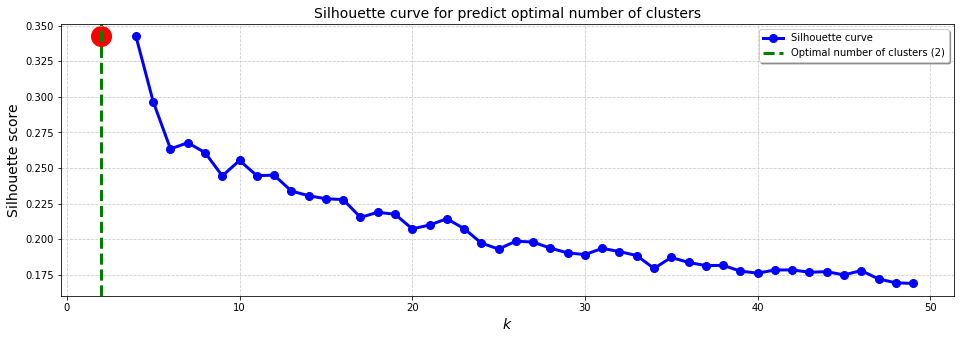

In [27]:
rcParams['figure.figsize'] = 16, 5
_ = plt.plot(range(4, 50), silhouette_score_array, "bo-", color='blue', linewidth = 3, markersize = 8, label = 'Silhouette curve')
_ = plt.xlabel("$k$", fontsize=14, family = "Arial")
_ = plt.ylabel("Silhouette score", fontsize=14, family = "Arial")
_ = plt.grid(which = "major", color = "#cccccc", linestyle = "--")
_ = plt.title("Silhouette curve for predict optimal number of clusters", family = "Arial", fontsize = 14)

k = np.argmax(silhouette_score_array) + 2

_ = plt.axvline(x = k, linestyle = "--", c = "green", linewidth = 3, label = "Optimal number of clusters ({})".format(k))
_ = plt.scatter(k, silhouette_score_array[k - 2], c = 'red', s = 400)
_ = plt.legend(shadow = True)
_ = plt.show()

In [28]:
print("The optimal number of FFHQ dataset {}.".format(k))

The optimal number of FFHQ dataset 2.


In [29]:
#davies bouldin score
kmeans_score = KMeans(n_clusters = 5, random_state = 22).fit(x)
labels = kmeans_score.labels_
metrics.davies_bouldin_score(x, labels)

1.0408086879783747

In [30]:
#calinski harabasz score 
kmeans_score = KMeans(n_clusters = 5, random_state = 22).fit(x)
labels = kmeans_score.labels_
metrics.calinski_harabasz_score(x, labels)

4444.231108101185

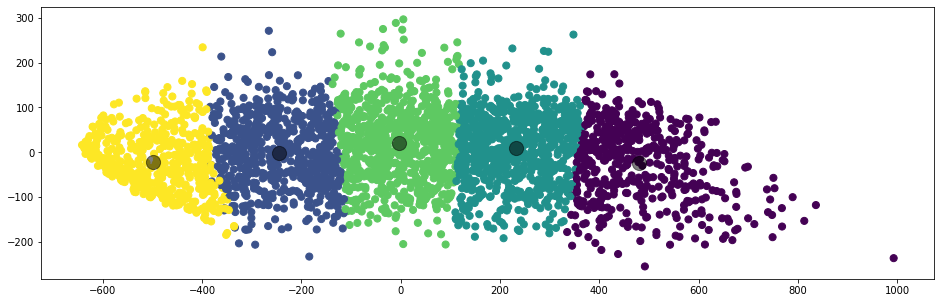

In [31]:
#visualise clusters 
kmeans_visual = KMeans(n_clusters = 5, random_state = 22).fit(x)
y_means = kmeans_visual.predict(x)

plt.scatter(x[:, 0], x[:, 1], c = y_means, s = 50, cmap = 'viridis')

centers = kmeans_visual.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c = 'black', s = 200, alpha = 0.5);

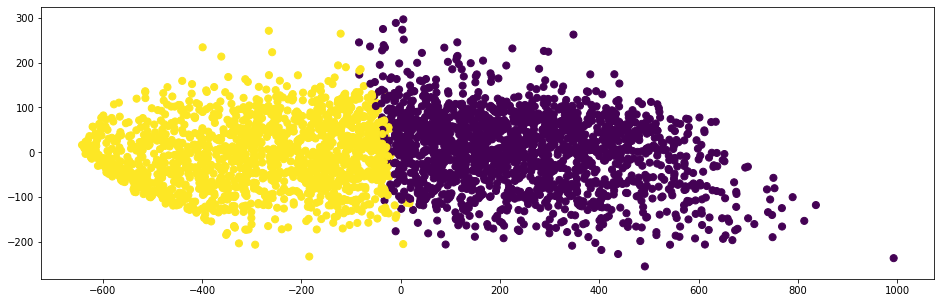

In [32]:
#make moon
model_spec = SpectralClustering(n_clusters = 2, affinity = 'nearest_neighbors', assign_labels = 'kmeans')
labels = model_spec.fit_predict(x)
plt.scatter(x[:, 0], x[:, 1], c=labels, s=50, cmap="viridis")

In [34]:
k = 5
km = KMeans(n_clusters = k, init = 'k-means++', max_iter = 100, n_init = 5, verbose = 1)
km.fit(x)

Initialization complete
Iteration 0, inertia 87794808.0
Iteration 1, inertia 63479576.0
Iteration 2, inertia 62955192.0
Iteration 3, inertia 62802400.0
Iteration 4, inertia 62732680.0
Iteration 5, inertia 62692496.0
Iteration 6, inertia 62669744.0
Iteration 7, inertia 62661968.0
Iteration 8, inertia 62658392.0
Iteration 9, inertia 62657048.0
Iteration 10, inertia 62656600.0
Iteration 11, inertia 62655968.0
Iteration 12, inertia 62655904.0
Converged at iteration 12: strict convergence.
Initialization complete
Iteration 0, inertia 89077008.0
Iteration 1, inertia 64385816.0
Iteration 2, inertia 63198184.0
Iteration 3, inertia 62947232.0
Iteration 4, inertia 62851288.0
Iteration 5, inertia 62797368.0
Iteration 6, inertia 62749008.0
Iteration 7, inertia 62706968.0
Iteration 8, inertia 62688584.0
Iteration 9, inertia 62676900.0
Iteration 10, inertia 62667512.0
Iteration 11, inertia 62656672.0
Iteration 12, inertia 62651024.0
Iteration 13, inertia 62649468.0
Iteration 14, inertia 62649056.0
I

KMeans(max_iter=100, n_clusters=5, n_init=5, verbose=1)

In [35]:
tfs_reduced = TruncatedSVD(n_components = k, random_state = 0).fit_transform(x)
tfs_embedded = TSNE(n_components = 2, perplexity = 40, verbose = 2).fit_transform(tfs_reduced)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3320 samples in 0.004s...
[t-SNE] Computed neighbors for 3320 samples in 0.203s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3320
[t-SNE] Computed conditional probabilities for sample 2000 / 3320
[t-SNE] Computed conditional probabilities for sample 3000 / 3320
[t-SNE] Computed conditional probabilities for sample 3320 / 3320
[t-SNE] Mean sigma: 33.817002
[t-SNE] Computed conditional probabilities in 0.468s
[t-SNE] Iteration 50: error = 75.3491898, gradient norm = 0.0629900 (50 iterations in 3.572s)
[t-SNE] Iteration 100: error = 66.8113861, gradient norm = 0.0074590 (50 iterations in 3.218s)
[t-SNE] Iteration 150: error = 66.1060562, gradient norm = 0.0048553 (50 iterations in 2.496s)
[t-SNE] Iteration 200: error = 65.8720779, gradient norm = 0.0027813 (50 iterations in 2.731s)
[t-SNE] Iteration 250: error = 65.7385559, gradient norm = 0.0028763 (50 iterations in 2.377s)
[t-SNE] KL divergence after 250 itera

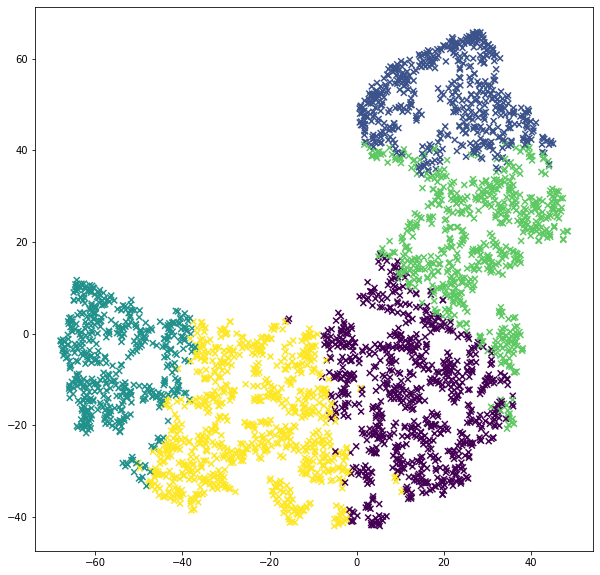

In [36]:
#t-SNE application 
fig = plt.figure(figsize = (10, 10))
ax = plt.axes()
plt.scatter(tfs_embedded[:, 0], tfs_embedded[:, 1], marker = 'x', c = km.labels_)
plt.show()